In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Deep Factorization Machine for Click-Through Rate Prediction

In a click-through rate (CTR) prediction scenario, we want to predict the likelihood that a user will click on a given ad. In this case, each input feature might represent different aspects of the user, the ad, and the context, such as:

User features: age, gender, interests, etc.
Ad features: ad category, advertiser ID, etc.
Context features: time of day, device type, etc.

We'll set up our DeepFM model with these hypothetical fields, using embeddings to capture meaningful feature interactions that influence whether or not a user will click on an ad. For simplicity, let's assume the following field dimensions:

User features: 2 fields, one for age with 10 possible categories and one for gender with 2 categories.
Ad features: 2 fields, one for ad category with 5 categories and one for advertiser ID with 20 categories.
Context features: 1 field for device type with 3 categories.

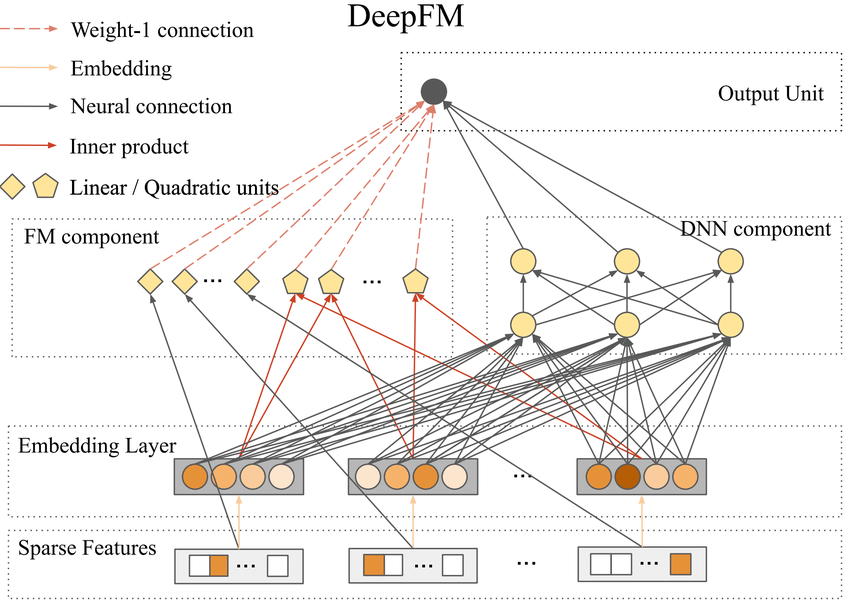

In [2]:
class CTRDeepFM(nn.Module):
    def __init__(self, field_dims, embedding_dim, hidden_dims):
        super().__init__()

        # Embedding layer for all fields (num of age, gender, ad_category, etc.)
        self.embedding = nn.Embedding(sum(field_dims), embedding_dim)

        # Offsets each field’s indices to make sure embeddings are uniquely referenced across fields
        self.offsets = torch.tensor([0] + field_dims[:-1]).cumsum(dim=0)

        # FM component for second-order interactions
        # Capture pairwise interactions between features as the dot (inner) product of their embeddings
        self.linear = nn.Embedding(sum(field_dims), 1)

        # Deep component (DNN) for higher-order interactions
        # flattened embeddings -> fully connected layers
        # learn non-linear relationships among user, ad, and context features
        all_dims = [len(field_dims) * embedding_dim] + hidden_dims
        self.dnn = nn.Sequential()
        for i in range(1, len(all_dims)):
            self.dnn.add_module(f"fc{i}", nn.Linear(all_dims[i - 1], all_dims[i]))
            self.dnn.add_module(f"relu{i}", nn.ReLU())
            self.dnn.add_module(f"dropout{i}", nn.Dropout(p=0.2))

        # Output layer
        self.dnn_output = nn.Linear(all_dims[-1], 1)

    def forward(self, x):
        x = x + self.offsets.to(x.device)  # Adjust feature indices for embedding lookup
        embeddings = self.embedding(x)

        # First-order linear part
        linear_part = self.linear(x).sum(dim=1)

        # Second-order FM part (pairwise interactions)
        square_of_sum = embeddings.sum(dim=1).pow(2)
        sum_of_square = (embeddings.pow(2)).sum(dim=1)
        second_order_part = 0.5 * (square_of_sum - sum_of_square).sum(
            dim=1, keepdim=True
        )

        # Deep component
        dnn_input = embeddings.view(embeddings.size(0), -1)  # Flatten embeddings
        dnn_part = self.dnn(dnn_input)
        dnn_output = self.dnn_output(dnn_part)

        # Sum linear, FM, and DNN parts
        output = linear_part + second_order_part + dnn_output
        return torch.sigmoid(output.squeeze(1))

# AI Explanation:

The DeepFM model combines a Factorization Machine (FM) component for capturing second-order feature interactions and a Deep Neural Network (DNN) component for capturing higher-order interactions. Let’s break down the parts of the code and map them to each section of the architecture shown in the image:

1. Embedding Layer
In the code, the embedding layer is defined as:

```python
self.embedding = nn.Embedding(sum(field_dims), embedding_dim)
```
This layer is where the input features (e.g., user and ad features) are converted into dense vector representations. In the image, this corresponds to the "Embedding Layer," which takes sparse features and maps them to continuous embeddings.
The offsets variable ensures that each field (like age, gender, or ad category) has unique embedding indices.


2. FM Component (Second-order interactions)
The FM component captures pairwise (second-order) interactions between features. In the code, this is handled in two parts:

First-order Linear Part:
```python
self.linear = nn.Embedding(sum(field_dims), 1)
linear_part = self.linear(x).sum(dim=1)
```

This part computes the first-order (linear) component of the FM. It assigns a weight to each feature and sums them, represented by the "Linear / Quadratic units" in the FM component of the image.
Second-order Pairwise Interactions:
```python
square_of_sum = embeddings.sum(dim=1).pow(2)
sum_of_square = (embeddings.pow(2)).sum(dim=1)
second_order_part = 0.5 * (square_of_sum - sum_of_square).sum(dim=1, keepdim=True)
```

This part calculates pairwise interactions between embeddings using the "inner product" (dot product) of embeddings.
The formula involves calculating the square of the sum of embeddings minus the sum of squares. This is an efficient way to compute pairwise interactions for all embeddings in a differentiable way, capturing interactions without explicitly computing every possible pair.
The inner product here represents the interaction strength between pairs of features and is shown as "Inner Product" connections in red lines in the image.

3. DNN Component (Higher-order interactions)
The DNN component captures higher-order, non-linear relationships between features. In the code, this is implemented with a sequence of fully connected layers:

```python
all_dims = [len(field_dims) * embedding_dim] + hidden_dims
self.dnn = nn.Sequential()
for i in range(1, len(all_dims)):
    self.dnn.add_module(f"fc{i}", nn.Linear(all_dims[i - 1], all_dims[i]))
    self.dnn.add_module(f"relu{i}", nn.ReLU())
    self.dnn.add_module(f"dropout{i}", nn.Dropout(p=0.2))
```

This part takes the concatenated embeddings as input (flattened to a single vector) and passes them through several dense layers, with ReLU activations and dropout for regularization.
The DNN branch captures complex, higher-order relationships between features that the FM component alone might miss. This part corresponds to the "DNN component" in the image, where embeddings are fully connected and passed through hidden layers to capture non-linear interactions.

4. Output Layer
Finally, the output layer combines the outputs from the FM and DNN components to produce a single prediction:

```python
output = linear_part + second_order_part + dnn_output
return torch.sigmoid(output.squeeze(1))
```

The linear_part (first-order), second_order_part (pairwise interactions), and dnn_output (higher-order interactions) are added together to generate the final score.
The torch.sigmoid function is applied to produce a probability between 0 and 1, representing the likelihood that a person will click on an ad.
Summary
Embedding Layer: Converts input features into dense vector embeddings.
FM Component: Computes first-order and second-order interactions using linear weights and inner products.
DNN Component: Learns higher-order, non-linear feature interactions through fully connected layers.
Output Layer: Combines all parts and applies a sigmoid activation to get a click probability.
This design allows the model to capture both linear and complex interactions, making it well-suited for click-through rate prediction tasks in recommendation systems.

In [3]:
# Defining field dimensions based on our hypothetical ad click scenario
field_dims = [10, 2, 5, 20, 3]  # [age, gender, ad_category, advertiser_id, device_type]
embedding_dim = 8  # Dimension for each embedding vector
hidden_dims = [32, 16]  # DNN hidden layer dimensions

In [4]:
# Instantiate the model
model = CTRDeepFM(field_dims, embedding_dim, hidden_dims)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()  # Binary cross-entropy loss for click prediction

In [5]:
# Example batch of feature indices representing users, ads, and context
# Each row is a sample with categorical indices for age, gender, ad_category, advertiser_id, and device_type
x = torch.tensor(
    [
        [2, 1, 3, 10, 1],  # Example 1: User with specific feature values
        [7, 0, 4, 3, 0],  # Example 2: Another user with different feature values
        [1, 1, 2, 14, 2],  # Example 3
        [5, 0, 0, 8, 1],  # Example 4
    ]
)

# Forward pass to get click probabilities
output = model(x)
print(f"Click probability predictions: {output}")